<a href="https://colab.research.google.com/github/Lone5267/NLP_Learn/blob/master/DO_Pos_Tagger.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

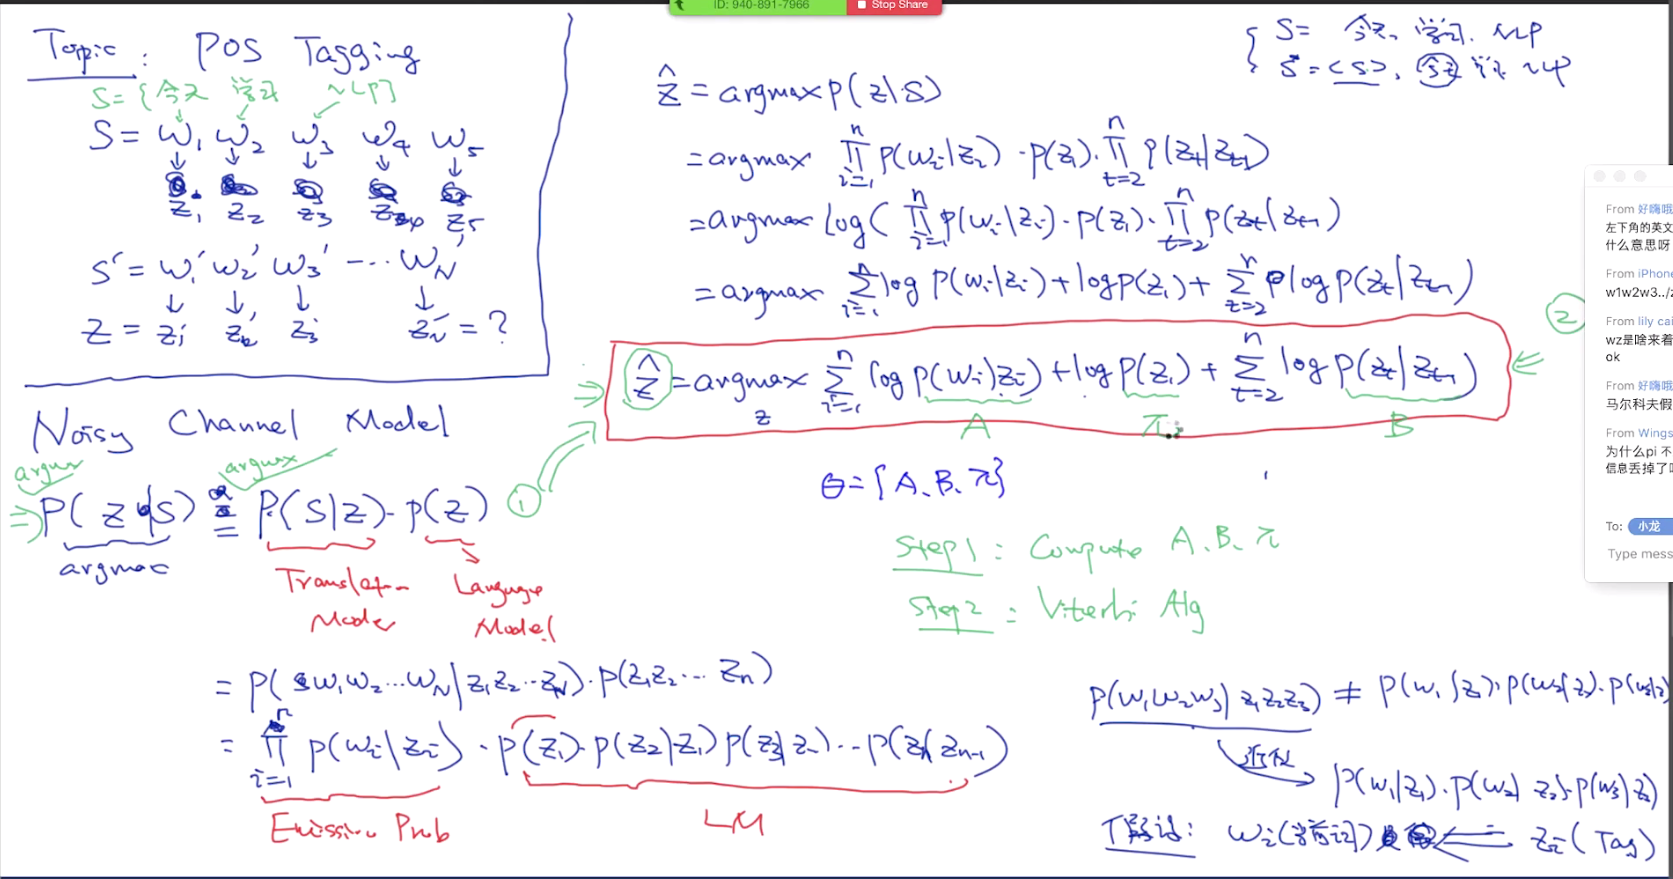

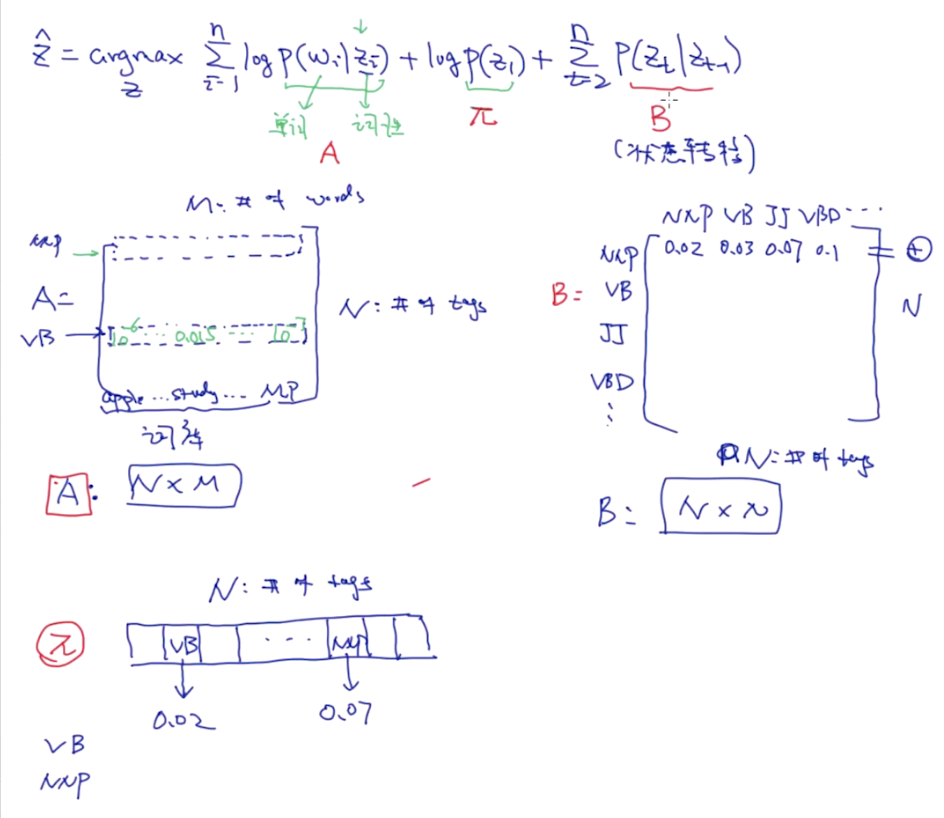

In [0]:
tag2id, id2tag = {}, {}
word2id, id2word = {}, {}

for line in open('/content/drive/My Drive/Colab Notebooks/DO WORK/PosTaggerData/traindata.txt'):
    items = line.split('/')
    word, tag = items[0], items[1].strip() #抽取每一行里的单词和磁性

    if word not in word2id:
        word2id[word] = len(word2id)
        id2word[len(id2word)] = word
    if tag not in tag2id:
        tag2id[tag] = len(tag2id)
        id2tag[len(id2tag)] = tag
    
M = len(word2id)  # M: 词典的大小
N = len(tag2id)   # N: 词性的种类个数
print(M, N)

18978 54


In [0]:
#构建 pi, A, N

import numpy as np

pi = np.zeros(N) #每个词性出现在句子中第一个位置的概率。
A = np.zeros((N, M)) #A[i][j]：给定tag i，出现单词j的概率。
B = np.zeros((N, N)) #B[i][j]：之前的状态是i，之后转换成状态j的概率。


In [0]:
prev_tagId = -1
for line in open('/content/drive/My Drive/Colab Notebooks/DO WORK/PosTaggerData/traindata.txt'):
    items = line.split('/')
    wordId, tagId = word2id[items[0].rstrip()], tag2id[items[1].rstrip()]
    if prev_tagId == -1: #这意味着句子的开始
        pi[tagId] += 1
    else: #如果不是句子开头
        B[prev_tagId][tagId] += 1
    
    A[tagId][wordId] +=1 #每次都要增加当前单词和tag的关系

    if items[0] == ".":
        prev_tagId = -1
    else:
        prev_tagId = tagId #更新前一个tagId为当前tagId

# normalize
pi = pi / sum(pi)
for i in range(N):
    A[i] /= sum(A[i])
    B[i] /= sum(B[i])
# 到此为止计算完了模型的所有参数 pi，A，B

In [0]:
print(pi)

[1.81324111e-01 0.00000000e+00 1.00049407e-02 3.33498024e-03
 3.95256917e-03 3.68083004e-02 1.11660079e-01 3.66847826e-02
 6.17588933e-04 3.81669960e-02 8.76976285e-03 5.18774704e-02
 6.02766798e-02 2.47035573e-04 2.17267787e-01 0.00000000e+00
 1.48221344e-03 6.05237154e-03 8.64624506e-04 2.47035573e-04
 0.00000000e+00 4.73073123e-02 0.00000000e+00 7.16403162e-03
 1.72924901e-03 2.09980237e-03 7.53458498e-02 6.36116601e-02
 2.59387352e-03 1.85276680e-03 5.92885375e-03 1.97628458e-03
 2.84090909e-03 0.00000000e+00 0.00000000e+00 2.71739130e-03
 5.92885375e-03 5.92885375e-03 9.88142292e-04 3.70553360e-04
 1.23517787e-04 0.00000000e+00 0.00000000e+00 1.85276680e-03
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00]


In [0]:
# prev_tag = ""
# for line in open('/content/drive/My Drive/Colab Notebooks/DO WORK/PosTaggerData/traindata.txt'):
#     items = line.split('/')
#     wordId, tagId = word2id[items[0]], tag2id[items[1].rstrip()]
#     if prev_tag == "":  # 这意味着是句子的开始
#         pi[tagId] += 1
#         A[tagId][wordId] += 1
#     else:  # 如果不是句子的开头
#         A[tagId][wordId] += 1
#         B[tag2id[prev_tag]][tagId] += 1
    
#     if items[0] == ".":
#         prev_tag = ""
#     else:
#         prev_tag = items[1].rstrip()

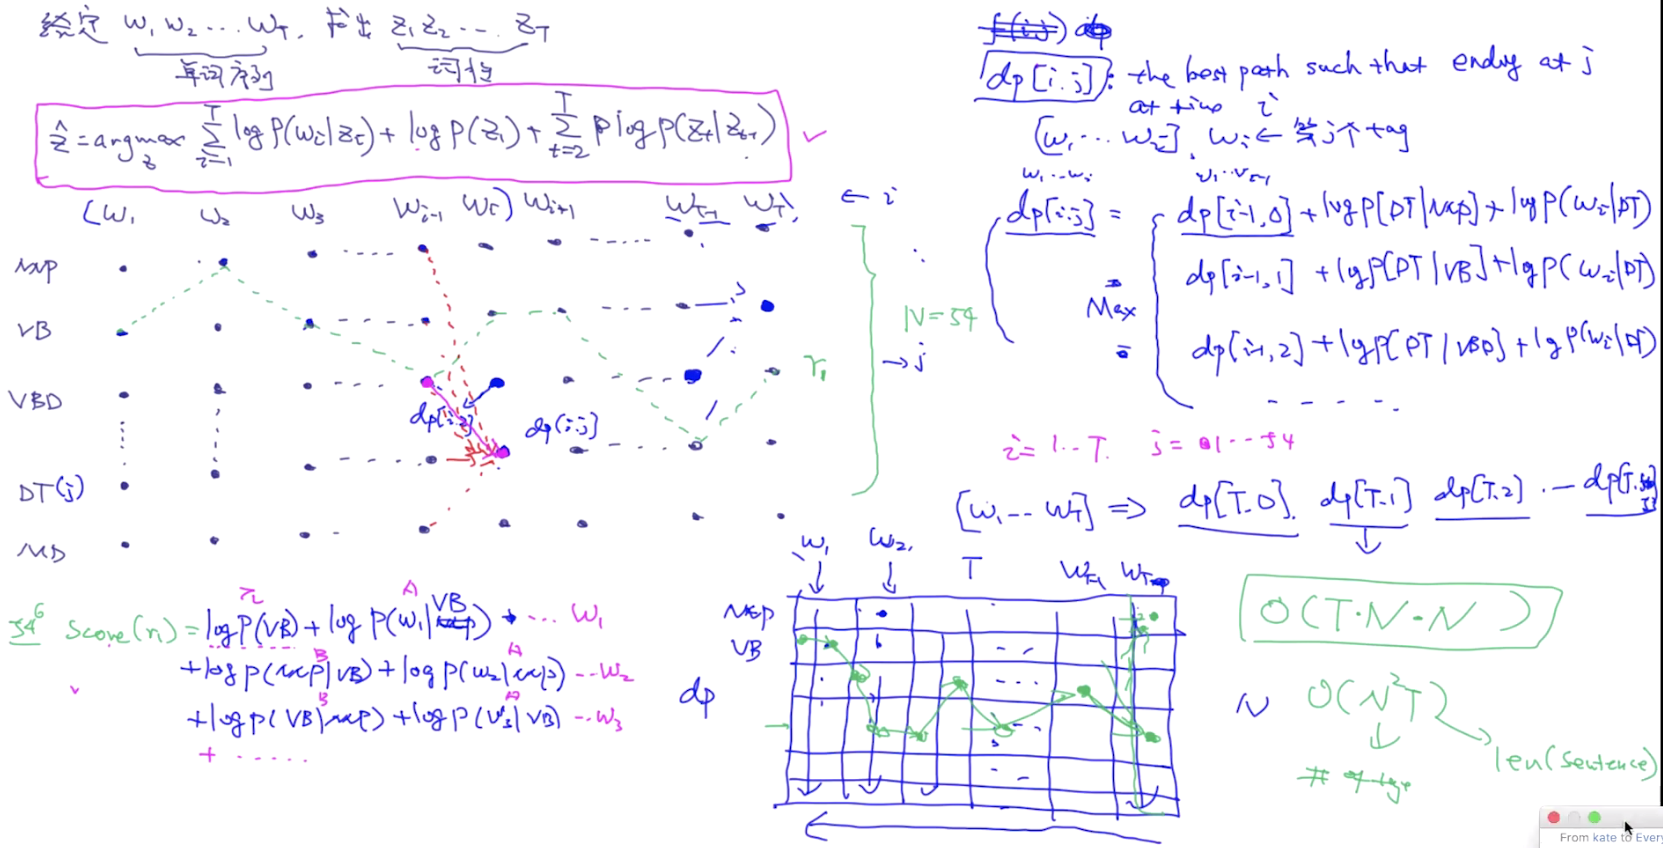

In [0]:
def log(v):
    if v == 0:
        return np.log(v + 0.000001)
    else:
        return v

In [0]:

def viterbi(x, pi, A, B):
    """
    x: user input string/sentence "I like play soccer"
    pip: initail probability of tags
    A: 给定tag，每个单词出现的概率
    B: tag之间的转移概率
    """ 
    x = [word2id[word] for word in x.split(" ")] # x: 每个单词的序号
    T = len(x)
    
    dp = np.zeros((T, N)) # dp[i][j]: w1...wi, 假设wi的tag是第j个tag
    ptr = np.zeros((T, N), dtype=int)

    for  j in range(N): #basecase for DP
        dp[0][j] = log(pi[j]) + log(A[j][x[0]])
    
    for i in range(1, T): #每个单词
        for j in range(N): #每个词性
            dp[i][j] = -99999
            for k in range(N): #从每一个k可以到达j
                score = dp[i-1][k] + log(B[k][j]) + log(A[j][x[i]]);
                if score > dp[i][j]:
                    dp[i][j] = score
                    ptr[i][j] = k
    
    # decoding: 把最好的tag sequence 打出来。
    best_seq = [0]*T #best_seq = [1, 5, 2, 24, 4]
    # step1：找出对应于最后一个单词的词性。
    best_seq[T-1] = np.argmax(dp[T-1])

    # step2：通过从后到前的循环来一次求出每个单词的词性
    for i in range(T - 2, -1, -1): # T-2, T-1,...,0
        best_seq[i] = ptr[i + 1][best_seq[i + 1]]
    
    print(x)
    #到目前为止，best_seq存放了对应于x的词性序列
    for i in range(len(best_seq)):
        print(id2tag[best_seq[i]])


In [34]:
x = "Social Security number , passport number and details about the services provided for the payment"

viterbi(x, pi, A, B)

[4475, 4476, 1062, 1, 4477, 1062, 16, 754, 108, 31, 4161, 2146, 14, 31, 4471]
NNP
NNP
NN
,
NN
NN
CC
NNS
IN
DT
NNS
VBN
IN
DT
NN
